In [91]:
# basic imports
import pandas as pd, matplotlib.pyplot as plt, numpy as np 
import IPython.display as ipd

In [92]:
# librosa - for CQT and visualisation
import librosa, librosa.display

In [93]:
# Interval for label storage
from intervaltree import Interval,IntervalTree

# Neural Network

## Import data

In [94]:
# import h5py to read in hdf5 files 
import h5py

filename ='musicnet.h5'
music_net = h5py.File(filename,'r')
type(music_net)

h5py._hl.files.File

In [95]:
# extract n songs from the database
n=5
source_list = list(music_net.keys())[:n]
source_list

['id_1727', 'id_1728', 'id_1729', 'id_1730', 'id_1733']

## Preprocessing

In [96]:
# init lists for storing results
cqt_container = [] # array to store the cqt for each song
cqt_shapes = [] # array to store the shapes of each cqt

print('initializing cqt transforms')
print('-'*60)
for id_ in source_list:
    print('extracting data from',id_)
    # extract the mono audio data and labels
    song = music_net[id_]
    music = song['data'][()]

    # downsampling
    sr = 44100
    sr_16k = 16000

    # resample to 16kHz to increase the the number of cqt points
    music = librosa.resample(music,sr,sr_16k)

    # CQT parameters
    sr_16k = sr_16k # downsampling to 16kHz
    hop_length = 512 # 32ms frames  
    bins_per_octave = 36 # corresponds to 7 octaves on the piano 
    # 7 x 36 = 252 number of bins 
    n_bins = 252 # frequency resolution 
    window = 'hann' # hanning window for smoothness

    # CQT absolute magnitude 
    C = np.abs(librosa.cqt(music,
                           sr = sr_16k , 
                           hop_length = hop_length,
                           bins_per_octave = bins_per_octave,
                           window = window,
                           n_bins = n_bins))
    # transpose to get the array in the correct format
    C = np.transpose(C)
    
    # append the length of this cqt to the length array 
    cqt_shapes.append(C.shape)
    
    # append to container
    cqt_container.append(C)

print('-'*60)
print('CQT transformation on each song complete')
print('-'*60)
print('CQT dimensions:', cqt_shapes)

initializing cqt transforms
------------------------------------------------------------
extracting data from id_1727
extracting data from id_1728
extracting data from id_1729
extracting data from id_1730
extracting data from id_1733
------------------------------------------------------------
CQT transformation on each song complete
------------------------------------------------------------
CQT dimensions: [(13971, 252), (7849, 252), (13891, 252), (11517, 252), (17063, 252)]


In [97]:
# extract and format labels 
labels_container = [] # array to store the labels of each song
labels_shapes = [] # array for storing label dimensions

# set up params for labels 
number_of_notes = 88 ## 88 piano notes 
hop_length = 512 # 32ms frames  
# counter to loop through cqt container 
i = 0 

print('constructing label vectors')
print('-'*60)

for id_ in source_list:
    # retrieve the song for this id 
    song = music_net[id_]
    raw_labels = song['labels'][()]
    
    # number of frames in this song
    number_frames = cqt_container[i].shape[0]
    i += 1  
    
    # binary labels - one hot encoding
    binary_labels = np.zeros((number_frames, number_of_notes))

    # init tree for slicing
    labels_tree = IntervalTree()
    # construct interval tree 
    for label in raw_labels: 
        pitch = label['note_id']
        start_time = label['start_time']
        end_time = label['end_time']
        labels_tree.addi(start_time,end_time,pitch)

    # resample the labels by finding the number of frames per second
    for frame in range(binary_labels.shape[0]):
        # slice the interval tree for notes in this frame 
        labels = labels_tree.at(frame*hop_length)
        for label in labels:
            # the labels vector is from 0 to 87 
            # 21 is the A0 on the piano
            pitch = label[2]-21 
            # if this pitch is active in this window 
            binary_labels[frame,pitch] = 1
    
    # append the binary_labels
    labels_container.append(binary_labels)
    # store label shapes 
    labels_shapes.append(binary_labels.shape)

print('labels preprocessed')
print('-'*60)
print('labels dimensions:', labels_shapes)

constructing label vectors
------------------------------------------------------------
labels preprocessed
------------------------------------------------------------
labels dimensions: [(13971, 88), (7849, 88), (13891, 88), (11517, 88), (17063, 88)]


In [98]:
# stack the containers vertically
X = np.vstack(cqt_container)
y = np.vstack(labels_container)
X.shape

(64291, 252)

In [9]:
# # save to txt files 
# np.save('preprocessed_cqt', X)
# np.save('preprocessed_labels', y)

In [10]:
# # load files
# X = np.load('preprocessed_cqt.npy')
# y = np.load('preprocessed_labels.npy')

## train-test split and normalization 

In [99]:
# split into training and test 
from sklearn.model_selection import train_test_split

# split into train, test and validation 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# # need to set split = 0.25 to get 60-20-20 split 
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.25, random_state=42)

In [100]:
# Normalization 
max_train = X_train.max()
min_train = X_train.min()
max_val = X_val.max()
min_val = X_val.min()
max_test = X_test.max()
min_test = X_test.min()

X_val_norm = (X_val - min_train)/(max_train - min_train)
X_test_norm = (X_test - min_train)/(max_train - min_train)
X_train_norm = (X_train - min_train)/(max_train - min_train)

# Compute the mean
train_mean = np.mean(X_train_norm, axis = 0)

# Subtract it
X_train_norm = X_train_norm - train_mean
X_val_norm = X_val_norm - train_mean
X_test_norm = X_test_norm - train_mean

# reassign for easy interpretation 
X_train = X_train_norm
X_val = X_val_norm
X_test = X_test_norm

## Define model 

In [136]:
# https://stackoverflow.com/questions/42158866/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu

import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 20 # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [144]:
from keras import backend as K

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [163]:
# import keras deep learning models  
from keras.layers import Dense, Dropout
from keras.models import Sequential 
from keras import losses
from tensorflow.keras.metrics import AUC

# model parameters 
layers = 3
hidden_nodes = 256
num_col = 252
output_nodes = 88
auc_score = AUC(name='auc')

# model type 
model = Sequential()

# input layer
model.add(Dense(num_col,kernel_initializer='normal', \
                activation='relu',input_shape=(num_col,)))

# hidden layers 
for i in range(layers): 
    model.add(Dense(hidden_nodes,activation='relu', kernel_initializer='normal'))
    
# output layer
model.add(Dense(output_nodes, activation='sigmoid',kernel_initializer='normal'))

# compile model - with accuracy,f1 measure metrics
model.compile(optimizer='adam', loss=weighted_binary_crossentropy,
              metrics=[auc_score,f1])
# get the initial weight
init_weights = model.get_weights()

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 252)               63756     
_________________________________________________________________
dense_162 (Dense)            (None, 256)               64768     
_________________________________________________________________
dense_163 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_164 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_165 (Dense)            (None, 88)                22616     
Total params: 282,724
Trainable params: 282,724
Non-trainable params: 0
_________________________________________________________________


## Fit the model

In [164]:
# early stop 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# patience = 10 
early_stopping_monitor = EarlyStopping(patience=10,mode='auto', verbose=1, min_delta=0, monitor='val_loss')
# this will save the best model and will not overwrite it
model_save = ModelCheckpoint('AMT_DNN_mean_squared_error.hdf5', monitor='val_loss', save_best_only=True)

# model params
batch_size = 32
epochs = 20

# fit the model
print('Fitting model to training data')
print('-'*60)

# set initial weights just incase
model.set_weights(init_weights)
model.fit(X_train,y_train,validation_data = (X_val, y_val), \
                    epochs = epochs, batch_size=batch_size,\
                    callbacks=[early_stopping_monitor,model_save], verbose = 1)

Fitting model to training data
------------------------------------------------------------
Train on 38574 samples, validate on 12858 samples
Epoch 1/30
38574/38574 [==============================] - 22s 564us/step - loss: 0.8261 - auc: 0.8337 - f1: 0.2045 - val_loss: 0.7909 - val_auc: 0.8564 - val_f1: 0.2247
Epoch 2/30
38574/38574 [==============================] - 20s 507us/step - loss: 0.7535 - auc: 0.8630 - f1: 0.2282 - val_loss: 0.7366 - val_auc: 0.8691 - val_f1: 0.2389
Epoch 3/30
38574/38574 [==============================] - 20s 507us/step - loss: 0.6984 - auc: 0.8741 - f1: 0.2496 - val_loss: 0.6744 - val_auc: 0.8793 - val_f1: 0.2647
Epoch 4/30
38574/38574 [==============================] - 20s 510us/step - loss: 0.6517 - auc: 0.8838 - f1: 0.2667 - val_loss: 0.6383 - val_auc: 0.8879 - val_f1: 0.2793
Epoch 5/30
38574/38574 [==============================] - 20s 513us/step - loss: 0.6114 - auc: 0.8917 - f1: 0.2831 - val_loss: 0.6036 - val_auc: 0.8952 - val_f1: 0.2870
Epoch 6/30
38

## model evaluation

In [165]:
# # load keras model 
# from keras.models import load_model 
# model = load_model('AMT_trained_DNN_trial_model.h5')

In [166]:
h = model.history

In [167]:
h.history.keys()

dict_keys(['val_loss', 'val_auc', 'val_f1', 'loss', 'auc', 'f1'])

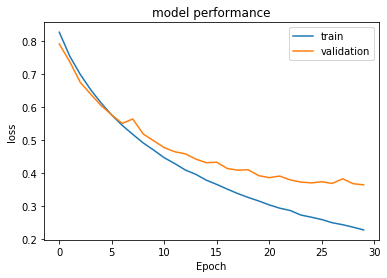

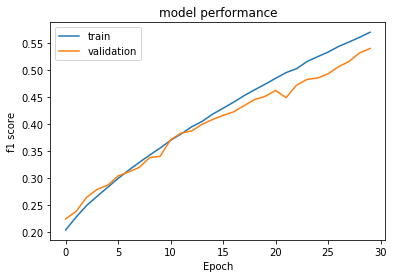

In [168]:
# use the test set and validate 
plt.figure()

# use the history metrics 
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.title('model performance')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','validation']);
plt.show()

# use the test set and validate 
plt.figure()

# use the history metrics 
plt.plot(h.history['f1'])
plt.plot(h.history['val_f1'])

plt.title('model performance')
plt.ylabel('f1 score')
plt.xlabel('Epoch')
plt.legend(['train','validation']);
plt.show()

## Predict with the model 

In [132]:
# # load keras model 
# from keras.models import load_model 
# model = load_model('AMT_trained_DNN_trial_model.h5')

In [169]:
# evaluate the model
model.evaluate(X_test,y_test)

12859/12859 [==============================] - 3s 265us/step


[0.36713738714460176, 0.960822343826294, 0.5423025488853455]

In [171]:
# parameters 
batch_size = 100 

print('making predictions on test set')
print('------------------------------')
# predict on test set
predictions = model.predict(X_test, batch_size = batch_size, verbose=1)

print('------------------------------')
print('predictions complete')

making predictions on test set
------------------------------
12859/12859 [==============================] - 0s 37us/step
------------------------------
predictions complete


In [135]:
# init true positives etc. 
TP = 0
FN = 0
FP = 0

# calculating model accuracy 
TP = np.count_nonzero(np.logical_and( predictions == 1, y_test == 1 ))
FN = np.count_nonzero(np.logical_and( predictions == 0, y_test == 1 ))
FP = np.count_nonzero(np.logical_and( predictions == 1, y_test == 0 ))
if (TP + FN) > 0:
    R = TP/float(TP + FN)
    P = TP/float(TP + FP)
    A = 100*TP/float(TP + FP + FN)
    if P == 0 and R == 0:
        F = 0
    else: 
        F = 100*2*P*R/(P + R)
else: 
    A = 0
    F = 0
    R = 0
    P = 0

print('model precision:', P)
print('model recall:', R)
print('F-measure:', F)
print('Accuracy:', A)

model precision: 0.9946581196581197
model recall: 0.9989270386266095
F-measure: 99.67880085653104
Accuracy: 99.35965848452508


In [68]:
# checking to ensure the model doesn't only predict zeros
# clear indication of problems with the model
predictions[predictions == 1].shape

(178,)

In [69]:
# number of active notes
y_test[y_test==1].shape

(48606,)

In [70]:
# total number of inactive/active notes 
y_test.shape[0]*y_test.shape[1]

1131592

In [73]:
# number of active notes
active_notes = y_test[y_test==1].shape[0]
# total number of inactive/active notes 
total_notes = y_test.shape[0]*y_test.shape[1]

inactive_notes = total_notes - active_notes
inactive_notes/active_notes

22.280911821585814

## Post-processing (reducing erroneous notes)

In [25]:
# clean model in adjacent frames based on the threshold 
# a is indexing notes
for a in range(predictions.shape[1]):
# j is indexing the frames 
    for j in range(2,predictions.shape[0]-3):
        # [1 0* 0 1]
        if predictions[j-1,a] == 1 and predictions[j,a] == 0 and predictions[j+1,a] == 0 and predictions[j+2,a] == 1:
            predictions[j,a] = 1
            predictions[j+1,a] = 1
        # [0 0 1* 1 0 0]
        if predictions[j-2,a] == 0 and predictions[j-1,a] == 0 and predictions[j,a] == 1 and predictions[j+1,a] == 1 and predictions[j+2,a] == 0 and predictions[j+3,a] == 0:
            predictions[j,a] = 0
            predictions[j+1,a] = 0
        # [0 1* 0 0]
        if predictions[j-1,a] == 0 and predictions[j,a] == 1 and predictions[j+1,a] == 0 and predictions[j+2,a] == 0:
            predictions[j,a] = 0
        # [1 0* 1 1]
        if predictions[j-1,a] == 1 and predictions[j,a] == 0 and predictions[j+1,a] == 1 and predictions[j+2,a] == 1:
            predictions[j,a] = 1

In [26]:
# init true positives etc. 
TP = 0
FN = 0
FP = 0

# calculating model accuracy 
TP = np.count_nonzero(np.logical_and( predictions == 1, y_test == 1 ))
FN = np.count_nonzero(np.logical_and( predictions == 0, y_test == 1 ))
FP = np.count_nonzero(np.logical_and( predictions == 1, y_test == 0 ))
if (TP + FN) > 0:
    R = TP/float(TP + FN)
    P = TP/float(TP + FP)
    A = 100*TP/float(TP + FP + FN)
    if P == 0 and R == 0:
        F = 0
    else: 
        F = 100*2*P*R/(P + R)
else: 
    A = 0
    F = 0
    R = 0
    P = 0

print('model precision:', P)
print('model recall:', R)
print('F-measure:', F)
print('Accuracy:', A)

model precision: 0.9952267303102625
model recall: 0.6598101265822784
F-measure: 79.35299714557564
Accuracy: 65.77287066246056
